In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import salamander

In [2]:
counts_sbs = pd.read_csv("data/pcawg_breast_sbs.csv", index_col=0)

# NMF with KL-divergence loss

In [3]:
n_signatures = 6

# NMF with Poisson noise
model = salamander.KLNMF(
    n_signatures=n_signatures,
    max_iterations=5000
)
model.fit(counts_sbs)

The fitted signatures and exposures of an NMF model can be accessed via $\texttt{model.signatures}$ and $\texttt{model.exposures}$ respecively:

In [4]:
model.signatures.head()

,Sig1,Sig2,Sig3,Sig4,Sig5,Sig6
A[C>A]A,0.000558,0.042001,0.002733,0.001515,0.017544,0.011871
A[C>A]C,0.000721,0.030924,0.000963,0.001621,0.011087,0.012307
A[C>A]G,0.000153,0.003165,0.000151,0.000019,0.002161,0.003004
A[C>A]T,0.000329,0.031758,0.001438,0.002422,0.005636,0.012699
C[C>A]A,0.001055,0.039412,0.002215,0.002002,0.009988,0.007789


In [5]:
model.exposures.head()

,SP10084,SP10150,SP10470,SP10563,SP10635,SP10944,SP11045,SP11171,SP11235,SP116331,...,SP8987,SP9251,SP9433,SP9481,SP96147,SP96163,SP96511,SP9816,SP9930,SP9979
Sig1,368.742014,2408.788660,3.564742e+02,1668.916256,86.933313,3966.741600,1547.030683,153.435000,189.573610,115.779669,...,831.210096,282.419525,5.045116e+03,2.583265,98.741441,1007.702291,809.986954,4.144899e+02,3.745192e+03,72.111735
Sig2,4103.168072,214.984124,3.620532e+03,272.612555,150.759788,1185.923847,250.467227,2024.068318,1074.942902,1706.303443,...,2728.748770,1055.802620,1.192093e-07,224.935169,573.530218,1665.726067,3655.561480,1.897084e+03,2.398579e+03,109.769999
Sig3,276.500009,2524.535984,7.186578e+02,298.032331,26.726934,2363.477201,1064.288452,122.312165,209.211300,171.861236,...,1132.286597,321.675963,6.647797e+03,31.952973,81.820362,1643.503898,1480.020458,6.611478e+02,4.780381e+03,31.668967
Sig4,70.486392,52.602996,2.040103e+02,24.290745,11.794148,68.300843,11.057570,55.009936,52.031885,110.282816,...,179.178681,1.491675,3.581918e+01,17.114614,21.187611,154.236640,297.837776,1.192093e-07,2.456081e+02,14.490304
Sig5,1763.992933,2064.002912,1.192093e-07,2104.837521,1274.208990,3460.418941,729.392772,538.328354,1723.928265,2374.468784,...,595.106177,761.716221,1.526116e+03,1279.110522,1819.011887,286.164668,276.447576,3.973429e+02,1.192093e-07,1061.741139


All implemented NMF models also come with methods to visualize the signatures, the exposures, and the signature or sample correlations:

array([<Axes: title={'center': 'Sig1'}>, <Axes: title={'center': 'Sig2'}>,
       <Axes: title={'center': 'Sig3'}>, <Axes: title={'center': 'Sig4'}>,
       <Axes: title={'center': 'Sig5'}>, <Axes: title={'center': 'Sig6'}>],
      dtype=object)

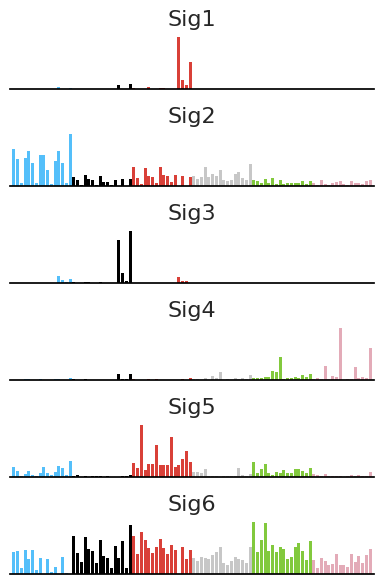

In [6]:
model.plot_signatures()

Like all other plotting methods, $\texttt{plot\_signatures()}$ just wraps around matplotlib and returns the matplotlib axes instances. This makes it effortless to apply custom modifications to a plot. For example, it is possible to rearrange the signature plots to our liking, widen all bars, and change the fontsize:

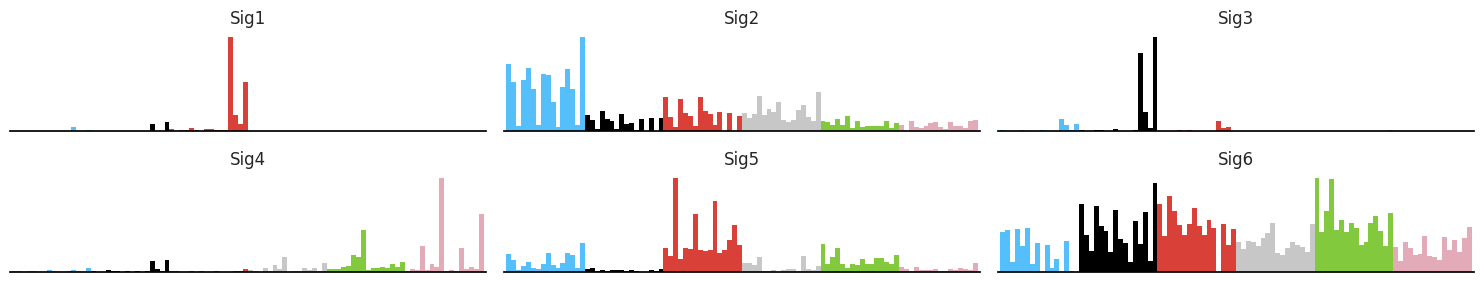

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(15, 3))
axes = model.plot_signatures(axes=axes, width=1)

for ax in axes.flatten():
    ax.set_title(ax.get_title(), fontsize=12)

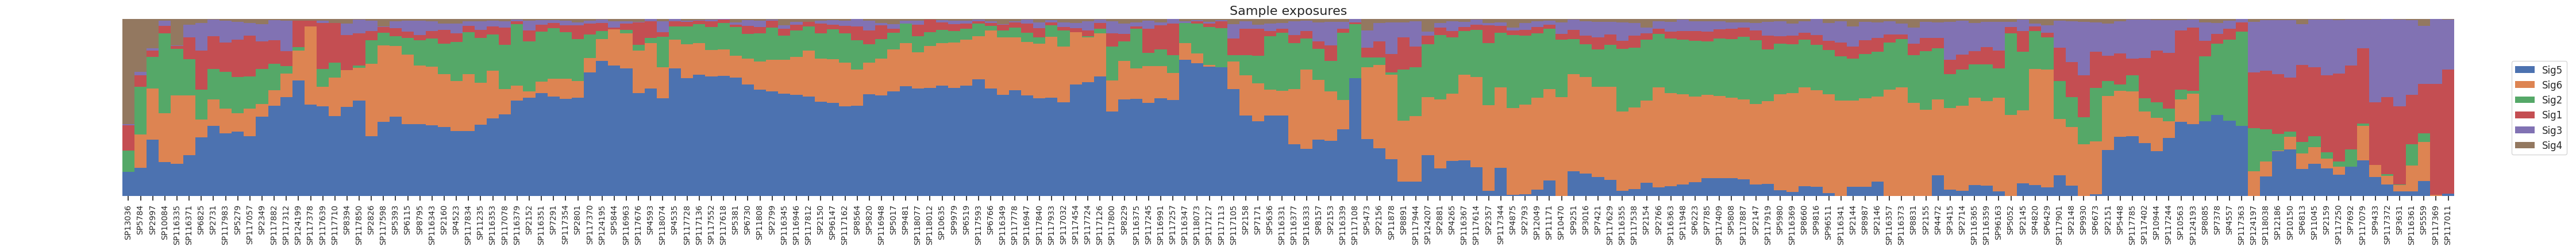

In [8]:
# stacked barplot of the exposures
_ = model.plot_exposures()

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

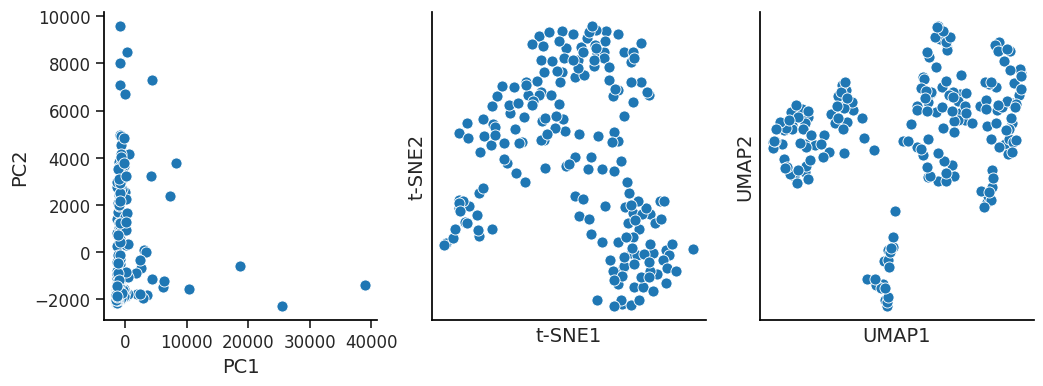

In [9]:
# PCA, t-SNE or UMAP of the sample exposures
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

model.plot_embeddings(method="pca", ax=axes[0])
model.plot_embeddings(method="tsne", ax=axes[1])
model.plot_embeddings(method="umap", ax=axes[2])

Let's say we want to color all samples with a high relative exposure to a certain signature. Again, the UMAP, t-SNE and PCA implementations just wrap around seaborns scatterplot and customizations can be made.

In [10]:
special_signature = "Sig6"
threshold = 0.4

relative_exposures = model.exposures / model.exposures.sum(axis=0)
relative_exposures = relative_exposures.T # signatures as columns
special_samples = relative_exposures.loc[relative_exposures[special_signature] >= threshold].index.to_numpy()

group_labels = [
    "special group" if sample in special_samples else "other"
    for sample in model.sample_names
]

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

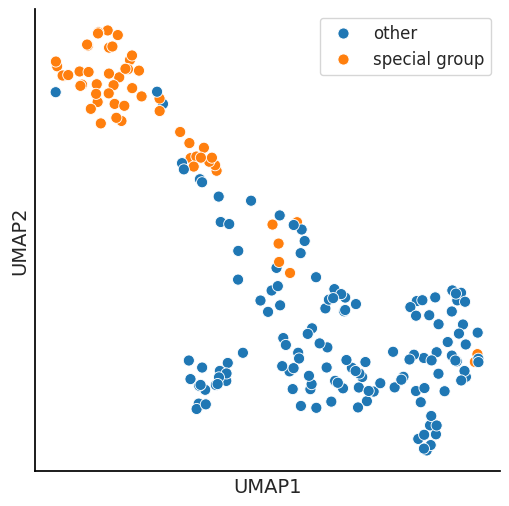

In [11]:
# colored UMAP
model.plot_embeddings(method="umap", hue=group_labels)

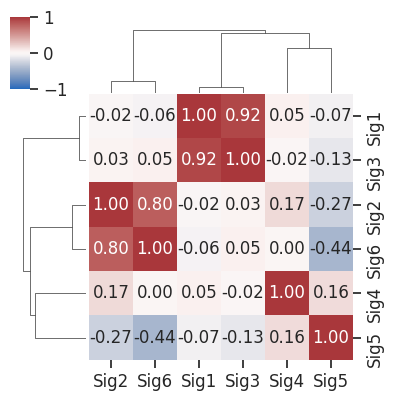

In [12]:
# signature correlations
# Pearson correlation of the exposures
model.plot_correlation(annot=True, figsize=(4,4))

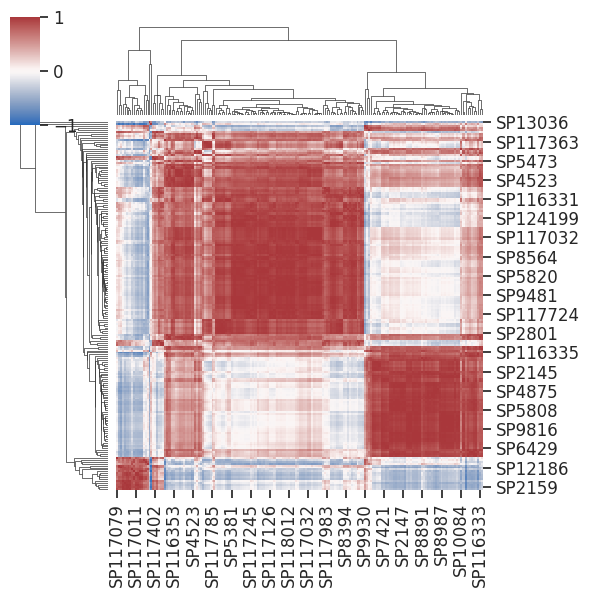

In [13]:
# sample correlations
model.plot_correlation(data="samples")

## Fixing a priori known signatures

Salamander supports fixing arbitrary many a priori known signatures during inference.

In [14]:
catalog = pd.read_csv("data/COSMIC_v3.3.1_SBS_GRCh38.csv", index_col=0)
my_known_signatures = catalog[["SBS3", "SBS13"]]

array([<Axes: title={'center': 'SBS3'}>,
       <Axes: title={'center': 'SBS13'}>,
       <Axes: title={'center': 'Sig1'}>, <Axes: title={'center': 'Sig2'}>,
       <Axes: title={'center': 'Sig3'}>, <Axes: title={'center': 'Sig4'}>,
       <Axes: title={'center': 'Sig5'}>], dtype=object)

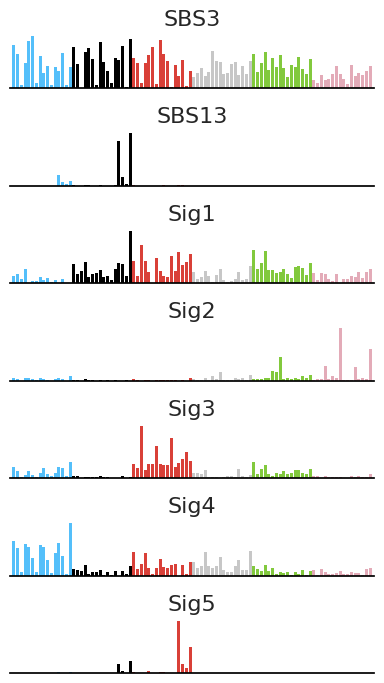

In [15]:
model = salamander.KLNMF(n_signatures=7, max_iterations=5000)
model.fit(counts_sbs, given_signatures=my_known_signatures)
model.plot_signatures()

# Other NMF models

The syntax for minimum volume NMF and correlated NMF is identical, and fixing a priori known signatures is also supported for these NMF models. In this tutorial, we only run these models for 3 iterations because of their longer runtime.

**Note**: The first iteration of an algorithm takes a while because the update rules for the parameters are just-in-time compiled with [numba](https://numba.pydata.org/). All subsequent iterations are much faster!

In [16]:
# lam: volume penalty hyperparameter in the loss function of mvNMF
model_mvnmf = salamander.MvNMF(
    n_signatures=n_signatures,
    lam=1,
    max_iterations=3
)
model_mvnmf.fit(counts_sbs)

In [17]:
# dim_embeddings: common embedding dimension of the signatures and samples
model_corrnmf = salamander.CorrNMFDet(
    n_signatures=n_signatures,
    dim_embeddings=n_signatures,
    max_iterations=3
)
model_corrnmf.fit(counts_sbs)

The only difference to the above visualizations with these models is that the embedding plot of CorrNMF shows the signature embeddings as well.

# Multimodal correlated NMF

Multimodal correlated NMF can process multiple data modalities at once assuming the input data of each modality originates from the identical samples.

In [18]:
counts_indel = pd.read_csv("data/pcawg_breast_indel.csv", index_col=0)

In [19]:
multi_model = salamander.MultimodalCorrNMF(
    n_modalities=2,
    ns_signatures=[5, 3],
    dim_embeddings=5,
    min_iterations=50,
    max_iterations=50
)
multi_model.fit(data=[counts_sbs, counts_indel], history=True)

The above cell should take about ten seconds to execute. We can examine the convergence of the algorithm by checking the history of the objective function.

**Important note**: The number of iterations specified above is insufficient and the obtained result is not meaningful. This tutorial only focuses on the usage of the package, not on any results.

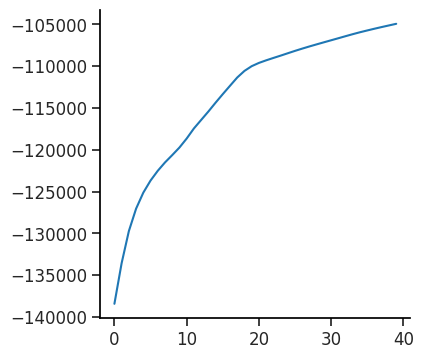

In [20]:
history = multi_model.history["objective_function"]

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(np.arange(len(history[10:])), history[10:])

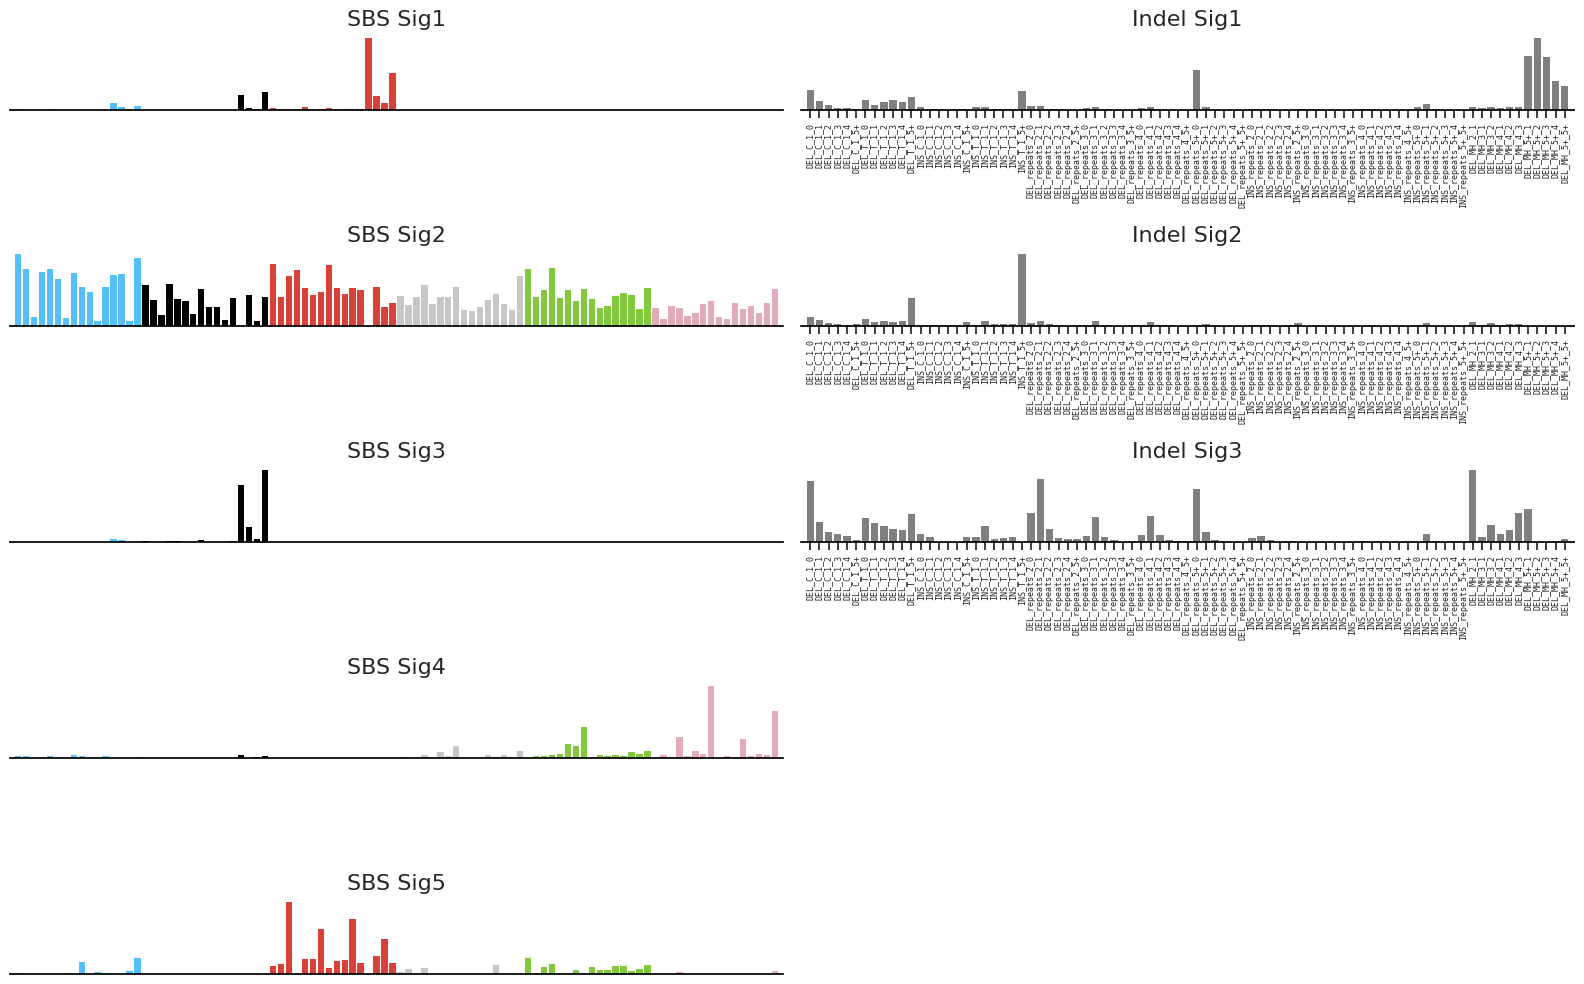

In [21]:
axes = multi_model.plot_signatures(annotate_mutation_types=True)

# remove mutation type annotations for the SBS signatures
for ax in axes[:,0]:
    ax.set_xticks([])

for ax in axes.flatten():
    ax.tick_params(axis="x", which="major", labelsize=6)

plt.tight_layout()

array([<Axes: title={'center': 'SBS signature exposures'}>,
       <Axes: title={'center': 'Indel signature exposures'}>],
      dtype=object)

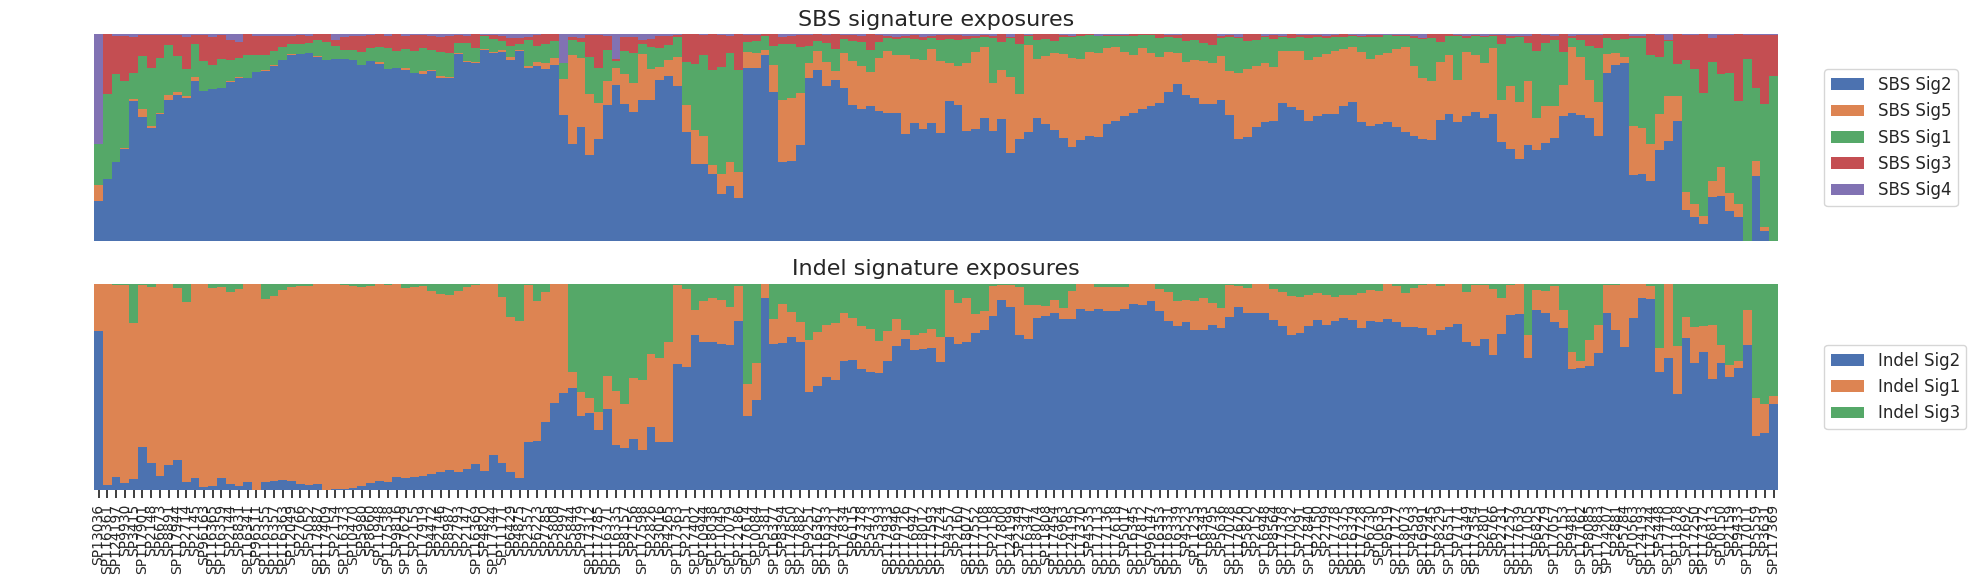

In [22]:
# exposures for each data modality
# samples are ordered jointly
multi_model.plot_exposures()

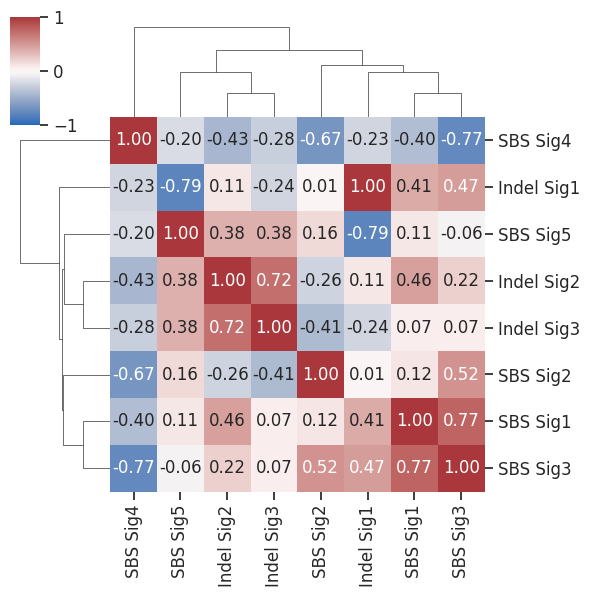

In [23]:
multi_model.plot_correlation(figsize=(6, 6), annot=True)

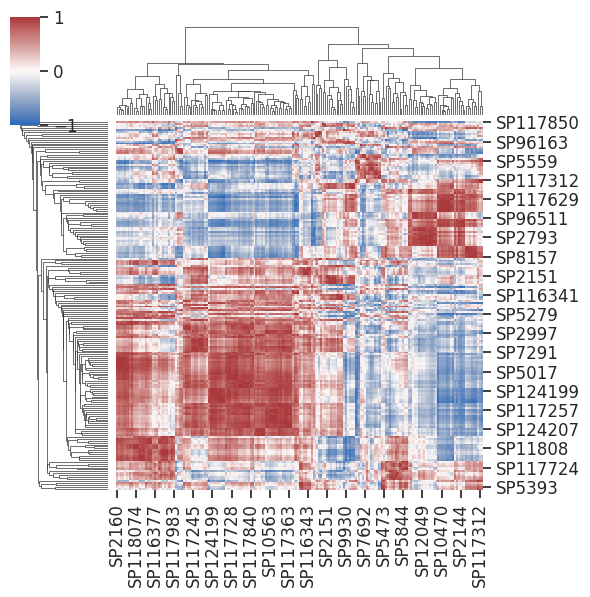

In [24]:
multi_model.plot_correlation(data="samples")

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

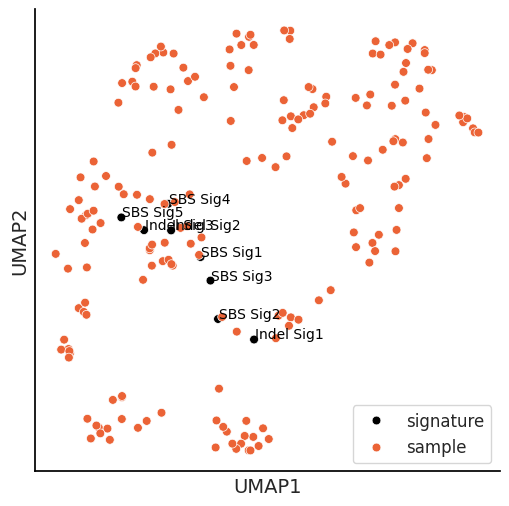

In [25]:
# change the color of the points in the embedding plot
palette = [(0, 0, 0), (0.92, 0.39, 0.21)]
hue = np.sum(multi_model.ns_signatures) * ["signature"] + multi_model.n_samples * ["sample"]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
multi_model.plot_embeddings(
    method="umap",
    hue=hue,
    palette=palette,
    s=40,
    annotation_kwargs={"fontsize": 10},
    ax=ax
)

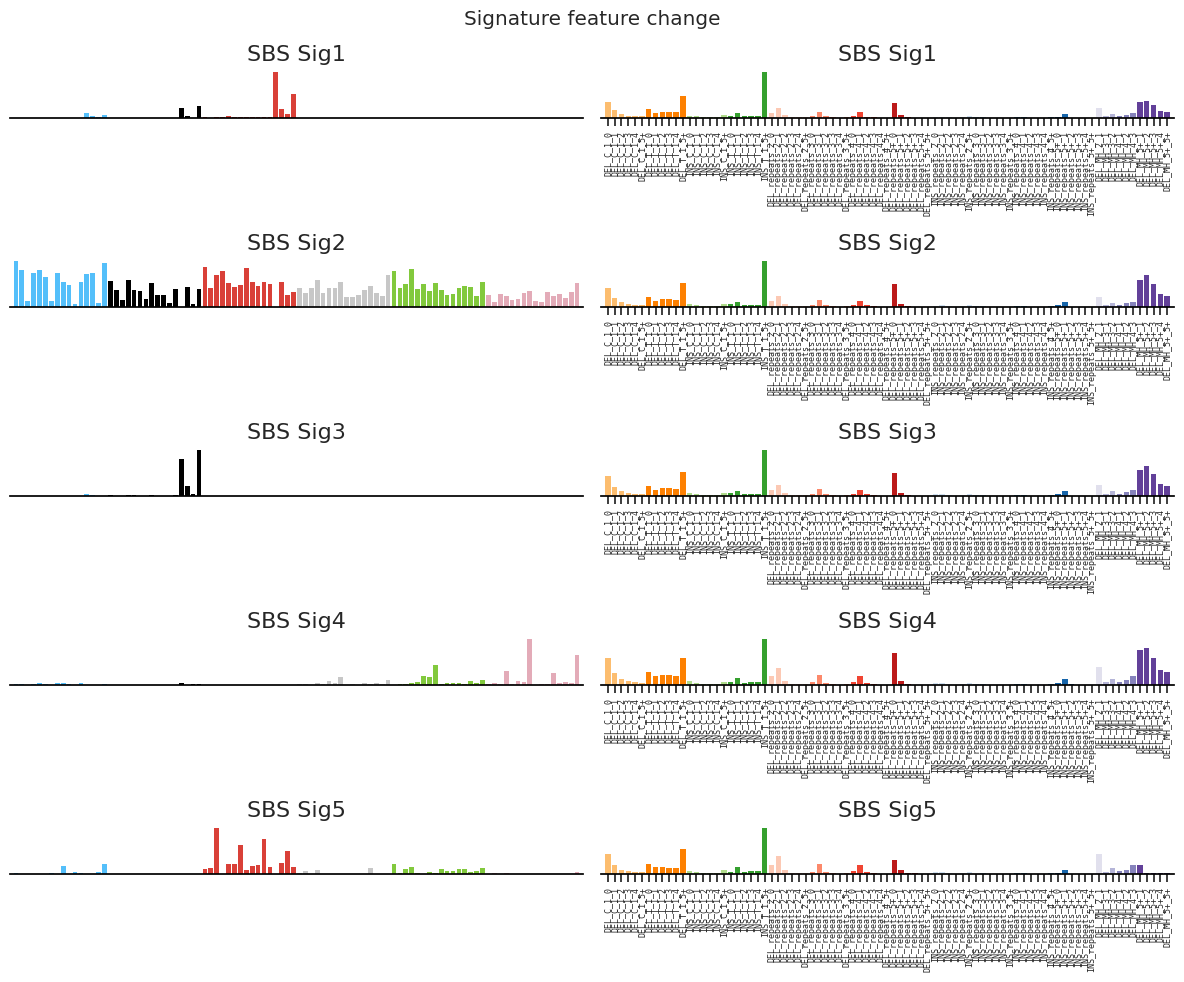

In [26]:
# co-occuring Indel spectra of all SBS signatures
axes = multi_model.plot_feature_change(
    in_modality="SBS",
    colors=["SBS96", "Indel83"],
    annotate_mutation_types=True,
    figsize=(12, 10)
)

for ax in axes[:,0]:
    ax.set_xticks([])

for ax in axes.flatten():
    ax.tick_params(axis="x", which="major", labelsize=6)

plt.tight_layout()